In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect, extract

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [10]:
# Create inspector object to inspect tables in the column
inspector= inspect(engine) 

In [11]:
# Check Measurement columns
meas_cols= inspector.get_columns('measurement')
for i in meas_cols:
    print(i["name"],i["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [12]:
# Change Measurement.date column to DATE type
# Note: This doesn't really do anything, but it does satisfy something inside my soul.
meas_cols[2]['type']= sqlalchemy.types.DATE

In [13]:
# Ah, much better
meas_cols= inspector.get_columns('measurement')
for i in meas_cols:
    print(i["name"],i["type"])

id INTEGER
station TEXT
date DATE
prcp FLOAT
tobs FLOAT


In [14]:
#Check Station columns
station_cols= inspector.get_columns('station')
for i in station_cols:
    print(i["name"],i["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


# Exploratory Climate Analysis

In [15]:
# Query the last year of stats and save to variable
last_year= session.query(Measurement).filter(Measurement.date >= '2016-08-23')

In [16]:
# Assign values from query into lists for adding to DataFrame
last_year_prcp_list= [i.prcp for i in last_year]
last_year_station_list= [i.station for i in last_year]
last_year_id_list= [i.id for i in last_year]
last_year_tobs_list= [i.tobs for i in last_year]
last_year_date_list= [i.date for i in last_year]

In [17]:
# Save the query results as a Pandas DataFrame and set the index to the date column
last_year_df= pd.DataFrame({
    "Precipitation": last_year_prcp_list,
    "Station": last_year_station_list,
    "id": last_year_id_list,
    "tobs": last_year_tobs_list,
    "Date": last_year_date_list
})

# Sort the dataframe by date
last_year_df.sort_values("Date", inplace= True)

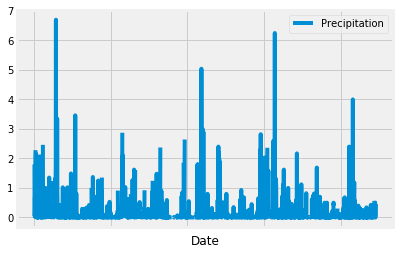

In [18]:
# Use Pandas Plotting with Matplotlib to plot the data
last_year_df.plot("Date","Precipitation")

plt.show()

In [19]:
# Inspect the last_year_df
last_year_df.head()

,Precipitation,Station,id,tobs,Date
0,0.00,USC00519397,2364,81.0,2016-08-23
1009,NaN,USC00517948,8825,80.0,2016-08-23
1529,1.79,USC00519281,14608,77.0,2016-08-23
704,0.05,USC00514830,7331,80.0,2016-08-23
361,0.15,USC00513117,5091,76.0,2016-08-23


In [20]:
# Use Pandas to calcualte the summary statistics for the precipitation data
last_year_df.describe()

,Precipitation,id,tobs
count,2021.000000,2230.000000,2230.000000
mean,0.177279,10158.570404,74.590583
std,0.461190,5603.500203,4.611667
min,0.000000,2364.000000,58.000000
25%,0.000000,5287.250000,72.000000
50%,0.020000,8930.500000,75.000000
75%,0.130000,14750.750000,78.000000
max,6.700000,19550.000000,87.000000


In [21]:
# Design a query to show how many stations are available in this dataset?
no_of_stations= session.query(func.count(Station.station)).all()
no_of_stations

[(9)]

In [22]:
# Create list of desired columns from the tables for join
sel= [Station.station, Station.name, Station.latitude, Station.longitude, Station.elevation,
      Measurement.station, Measurement.date, Measurement.prcp, Measurement.tobs]

# Join the tables on the .station columns and assign to DF
measurement_station_join_df= pd.DataFrame(
                            session
                           .query(*sel)
                           .filter(Station.station == Measurement.station)
                           .all(),
                            columns= ["Station.station", "Station.name", "Station.latitude", "Station.longitude", "Station.elevation",
    "Measurement.station", "Measurement.date", "Measurement.prcp", "Measurement.tobs"]
)

# Drop redundant .station column
measurement_station_join_df.drop(columns= "Measurement.station", inplace= True)

# Inspect measurement_station_join_df
measurement_station_join_df.head()

,Station.station,Station.name,Station.latitude,Station.longitude,Station.elevation,Measurement.date,Measurement.prcp,Measurement.tobs
0,USC00519397,"WAIKIKI 717.2, HI US",21.2716,-157.8168,3.0,2010-01-01,0.08,65.0
1,USC00519397,"WAIKIKI 717.2, HI US",21.2716,-157.8168,3.0,2010-01-02,0.00,63.0
2,USC00519397,"WAIKIKI 717.2, HI US",21.2716,-157.8168,3.0,2010-01-03,0.00,74.0
3,USC00519397,"WAIKIKI 717.2, HI US",21.2716,-157.8168,3.0,2010-01-04,0.00,76.0
4,USC00519397,"WAIKIKI 717.2, HI US",21.2716,-157.8168,3.0,2010-01-06,NaN,73.0


In [23]:
# Join the tables on the .station columns and assign to DF
measurement_station_group_by_df= pd.DataFrame(
                            session
                           .query(*sel,func.count(Station.station))
                           .filter(Station.station == Measurement.station)
                           .group_by(Station.station)
                           .order_by(func.count(Station.station).desc())
                           .all(),
                            columns= ["Station.station", "Station.name", "Station.latitude", "Station.longitude", "Station.elevation",
    "Measurement.station", "Measurement.date", "Measurement.prcp", "Measurement.tobs",
    "Station Count"]
)

# Assign Station as index
measurement_station_group_by_df.set_index("Station.station", inplace= True)

# Drop these columns as they are redundant or misleading
measurement_station_group_by_df.drop(columns= ["Measurement.station","Measurement.date"], inplace= True)

# Print measurement_station_group_by_df
measurement_station_group_by_df

,Station.name,Station.latitude,Station.longitude,Station.elevation,Measurement.prcp,Measurement.tobs,Station Count
Station.station,,,,,,,
USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9,0.15,70.0,2772
USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0,0.08,65.0,2724
USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6,0.28,67.0,2709
USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5,0.15,75.0,2669
USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4,0.14,73.0,2612
USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0,0.01,67.0,2202
USC00511918,"HONOLULU OBSERVATORY 702.2, HI US",21.31520,-157.99920,0.9,0.05,66.0,1979
USC00517948,"PEARL CITY, HI US",21.39340,-157.97510,11.9,NaN,75.0,1372
USC00518838,"UPPER WAHIAWA 874.3, HI US",21.49920,-158.01110,306.6,0.21,72.0,511


In [24]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
agg_temp_df= pd.DataFrame(measurement_station_join_df.loc[:,["Station.station","Measurement.date","Measurement.tobs"]])
agg_temp_list= [
    agg_temp_df["Measurement.tobs"].min(),
    agg_temp_df["Measurement.tobs"].max(),
    agg_temp_df["Measurement.tobs"].mean()
    ]

# Print agg_temp_list
agg_temp_list

[53.0, 87.0, 73.09795396419437]

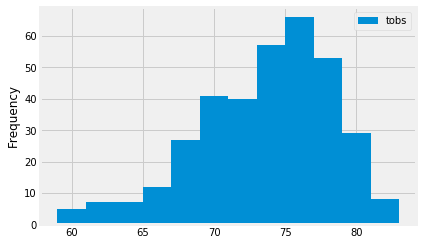

In [25]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
station_most_temps= last_year_df.loc[
    last_year_df['Station'] == measurement_station_group_by_df.iloc[0,:].name,
    :]

#Plot as histogram
station_most_temps["tobs"].plot.hist(bins= 12)
plt.legend()

plt.show()

In [26]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [27]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
last_year_calc_temps= calc_temps('2016-08-01', '2017-08-01')
last_year_calc_temps

[(58.0, 74.64288840262581, 87.0)]

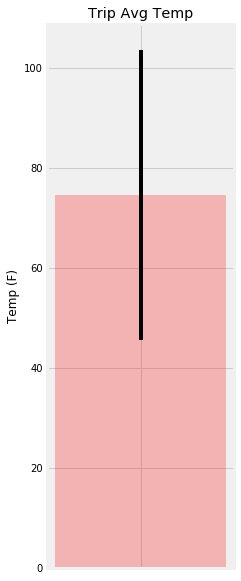

In [28]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

plt.figure(figsize= (3,10))

plt.bar(x= ""
        , height= last_year_calc_temps[0][1]
        , yerr= last_year_calc_temps[0][2] - last_year_calc_temps[0][0]
        , color= 'red'
        , alpha= 0.25
       )

plt.tick_params(axis='x', which= 'both', bottom=False, top= False, labelbottom= False)

plt.title("Trip Avg Temp")
plt.ylabel("Temp (F)")

plt.show()

In [29]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

start_date= '2017-08-01'
end_date= '2017-08-08'

total_prcp_last_year_query= (session
                             .query(Measurement.station,
                                    Station.name,
                                    Station.latitude,
                                    Station.longitude,
                                    Station.elevation,
                                    func.sum(Measurement.prcp))
                             .filter(Measurement.station == Station.station)
                             .filter(Measurement.date >= start_date)
                             .filter(Measurement.date <= end_date)
                             .group_by(Measurement.station)
                             .all()
                            )

total_prcp_last_year_query

[('USC00514830',
  'KUALOA RANCH HEADQUARTERS 886.9, HI US',
  21.5213,
  -157.8374,
  7.0,
  0.32),
 ('USC00516128',
  'MANOA LYON ARBO 785.2, HI US',
  21.3331,
  -157.8025,
  152.4,
  0.7),
 ('USC00519281',
  'WAIHEE 837.5, HI US',
  21.45167,
  -157.84888999999998,
  32.9,
  0.06),
 ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.04),
 ('USC00519523',
  'WAIMANALO EXPERIMENTAL FARM, HI US',
  21.33556,
  -157.71139,
  19.5,
  0.0)]

## Optional Challenge Assignment

In [30]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [31]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
start_date= "2017-08-01"
end_date= "2017-08-08"

# Use the start and end date to create a range of dates
date_range= (session
             .query(Measurement.date)
             .filter(Measurement.date >= start_date)
             .filter(Measurement.date <= end_date)
             .group_by(Measurement.date)
             .all()
            )

day_objects= list(set([i[0][5:10] for i in date_range]))

# Loop through the list of %m-%d strings and calculate the normals for each date
date_range_normals= [[i,daily_normals(i)] for i in day_objects]

In [32]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index

date= [i[0] for i in date_range_normals]
tmin= [i[1][0][0] for i in date_range_normals]
tavg= [i[1][0][1] for i in date_range_normals]
tmax= [i[1][0][2] for i in date_range_normals]

normals_df= pd.DataFrame({
    "date": date,
    "tmin": tmin,
    "tavg": tavg,
    "tmax": tmax
})

normals_df.set_index('date', inplace= True)
normals_df.sort_index(inplace= True)
normals_df

,tmin,tavg,tmax
date,,,
08-01,67.0,75.540000,83.0
08-02,68.0,75.603774,84.0
08-03,70.0,76.611111,85.0
08-04,69.0,76.711538,84.0
08-05,69.0,76.148148,82.0
08-06,67.0,76.250000,83.0
08-07,71.0,77.156863,83.0
08-08,68.0,76.557692,83.0


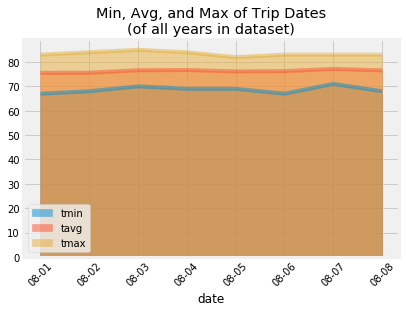

In [33]:
# Plot the daily normals as an area plot with `stacked=False`

ax= normals_df.plot.area(stacked= False,
                        title= "Min, Avg, and Max of Trip Dates\n(of all years in dataset)"
                        )

ax.set_xticks(range(normals_df.shape[0]))
ax.set_xticklabels(normals_df.index,rotation= 45)

plt.show()